<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%204/Inputs%20heterogeneos/house_opcion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Predicción del valor de venta de una casa**</h1></font>

<font color="#6E6E6E"><h1 align="left">Opción 1: Se realiza el modelo **solo** sobre variables numéricas</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>


In [ ]:
COLAB = True

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

%matplotlib inline

Adaptado de:

  https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

Que utiliza el dataset de:

https://arxiv.org/pdf/1609.08399.pdf

In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1nZ4bq0TsQn2x3bA-jvEvZylAT-c8bpQN',
                                        dest_path='./Houses-dataset.zip', unzip=True)

Unzipping...Done.


In [ ]:
!ls -la Houses-dataset

total 100
drwxr-xr-x 3 root root  4096 Nov 28 10:03 .
drwxr-xr-x 1 root root  4096 Nov 28 10:03 ..
-rw-r--r-- 1 root root 12029 Nov 28 10:03 HousesInfo.txt
drwxr-xr-x 2 root root 77824 Nov 28 10:03 photos


In [ ]:
!ls Houses-dataset/photos/165*

Houses-dataset/photos/165_bathroom.jpg	Houses-dataset/photos/165_frontal.jpg
Houses-dataset/photos/165_bedroom.jpg	Houses-dataset/photos/165_kitchen.jpg


In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import glob
import cv2

def load_house_attributes(inputPath):
    # initialize the list of column names in the CSV file and then
    # load it using Pandas
    cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
    df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
    # determine (1) the unique zip codes and (2) the number of data
    # points with each zip code
    zipcodes = df["zipcode"].value_counts().keys().tolist()
    counts = df["zipcode"].value_counts().tolist()
    # loop over each of the unique zip codes and their corresponding
    # count
    for (zipcode, count) in zip(zipcodes, counts):
      # the zip code counts for our housing dataset is *extremely*
      # unbalanced (some only having 1 or 2 houses per zip code)
      # so let's sanitize our data by removing any houses with less
      # than 25 houses per zip code
      if count < 25:
          idxs = df[df["zipcode"] == zipcode].index
          df.drop(idxs, inplace=True)
    # return the data frame
    return df

In [ ]:
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])
    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoding, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])
    # return the concatenated training and testing data
    return (trainX, testX)

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input

In [ ]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
import locale

In [ ]:
!ls Houses-dataset

HousesInfo.txt	photos


In [ ]:
# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading house attributes...")
inputPath = "./Houses-dataset/HousesInfo.txt"
df = load_house_attributes(inputPath)

[INFO] loading house attributes...


In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
trainAttrX, testAttrX = train_test_split(df, test_size=0.25, random_state=42)

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

[INFO] processing data...


In [ ]:
trainAttrX.shape

(271, 10)

In [ ]:
df.shape

(362, 5)

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

def show_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

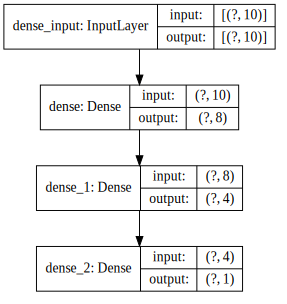

In [ ]:
model = Sequential()
model.add(Dense(8, activation="relu", input_shape=(10,)))
model.add(Dense(4, activation="relu"))
model.add(Dense(1))

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

show_model(model)

### Misma arquitectura pero programada con API funcional:

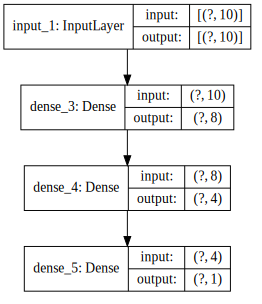

In [ ]:
inputs = Input(shape=(10,))
x = Dense(8, activation="relu", input_shape=(10,))(inputs)
x = Dense(4, activation="relu")(x)
x = Dense(1)(x)
model = Model(inputs, x)

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

show_model(model)

In [ ]:
trainAttrX.shape

(271, 10)

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_loss, val_loss):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_loss)), 100*np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), 100*np.array(val_loss))
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
trainAttrX.shape, trainY.shape

((271, 10), (271,))

In [ ]:
testAttrX.shape, testY.shape

((91, 10), (91,))

In [ ]:
acum_tr_loss  = []
acum_val_loss = []

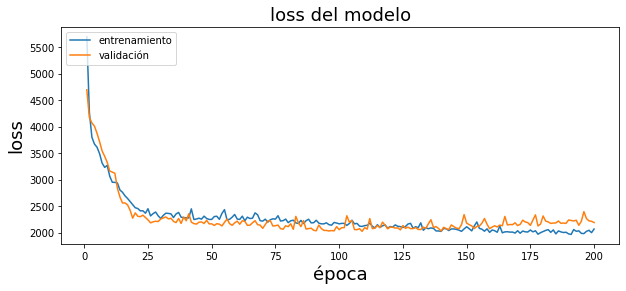

In [ ]:
# training:

filepath="model_current_best.h5"
batch_size=8
epochs = 200

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                              save_best_only=True,
                              mode='min') # graba sólo los que mejoran en validación

for e in range(epochs):
    history = model.fit(x=trainAttrX, y=trainY,
                        batch_size=batch_size,
                        epochs=1,
                        callbacks=[checkpoint],
                        verbose=1,
                        validation_data=(testAttrX, testY))
    
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_loss) > 1:
        clear_output()
        grafica_entrenamiento(acum_tr_loss, acum_val_loss)

In [ ]:
model = load_model('model_current_best.h5')

In [ ]:
score_tr = model.evaluate(trainAttrX, trainY, verbose=0)
print('Train loss    :', score_tr)

score_val = model.evaluate(testAttrX, testY, verbose=0)
print('Val loss    :', score_val)

Train loss    : 20.8298397064209
Val loss    : 20.253280639648438


In [ ]:
preds  = model.predict(testAttrX)

In [ ]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 20.25%, std: 21.11%
